In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.stats import norm, chi2

from prob_rob.motion_models import OdometryMotionModel
from prob_rob.data import read_simple_world, read_simple_data
from prob_rob.utils import normalize_angle, sample_normal_distribution
from prob_rob.robot import BaseRobot
from prob_rob.map import LandmarkMap

In [3]:
class EKFSLAMKnown:
    def __init__(self, pose, num_landmarks, motion_model=None):
        self.rsize = 3
        self.lmsize = 2
        
        landmark_pose = np.zeros((2*num_landmarks, 1))
        
        self.mean = np.concatenate((np.copy(pose), landmark_pose))
        self.cov = np.zeros((self.mean.size, self.mean.size))
        lm_cov = np.eye(2*num_landmarks)
        np.fill_diagonal(
            lm_cov,
            10**10
        )
        self.cov[self.rsize:, self.rsize:] = lm_cov

        self.motion_model = motion_model
        
    def get_mu_lid(self, lid):
        return self.rsize + self.lmsize*(lid - 1)
        
    def get_landmark(self, lid):
        mu_lid = self.get_mu_lid(lid)

        lx = self.mean[mu_lid,:].item(0)
        ly = self.mean[mu_lid+1,:].item(0)
        
        return (lx, ly)

    def predict(self, command):
        robot_pose = self.mean[:self.rsize, :]
        self.mean[:self.rsize, :] = self.motion_model.command_static(
            robot_pose, 
            command
        )

        # TODO: Put in motion model
        theta_n = normalize_angle(self.mean.item(2))
        rot1, trans, rot2 = command

        ang = normalize_angle(theta_n + rot1)
        Gtx = np.matrix([
            [1, 0, - trans * math.sin(ang)],
            [0, 1, trans * math.cos(ang)],
            [0, 0, 1],
        ])
        
        lmsize = self.mean.shape[0] - self.rsize
        
        r1zeros = np.zeros((self.rsize, lmsize))
        r2zeros = np.copy(r1zeros.T)
        
        gr1 = np.concatenate( (Gtx, r1zeros), axis=1 )
        gr2 = np.concatenate( (r2zeros, np.eye(lmsize)), axis=1)
        Gt = np.concatenate((gr1, gr2))
        
        # motion noise
        Rtx = np.matrix([
            [0.1, 0, 0],
            [0, 0.1, 0],
            [0, 0, 0.01]
        ])
        
        rr1zeros = np.zeros((self.rsize, lmsize))
        rr2zeros = np.copy(rr1zeros.T)
        
        rr1 = np.concatenate(
            (Rtx, rr1zeros), 
            axis=1
        )
        rr2 = np.concatenate( 
            (rr2zeros, np.zeros((lmsize, lmsize))),
            axis=1
        )
        Rt = np.concatenate((rr1, rr2))
        
        self.cov = Gt * self.cov * Gt.T + Rt
        
        return self.mean, self.cov

    def correct(self, measurements, local_map):
        # measurement noise
        Qt = np.eye(2) * 0.05
        
        rx = self.mean.item(0)
        ry = self.mean.item(1)
        rtheta = normalize_angle(self.mean.item(2))
        
        _mean = np.copy(self.mean)
        _cov = np.copy(self.cov)

        for reading in measurements:
            # TODO: Put in measurement model
            lid, srange, sbearing = reading
            z_measured = np.matrix([srange, normalize_angle(sbearing)]).T
            
            mu_lid = self.get_mu_lid(lid)

            # observation
            lx = 0
            ly = 0
            if not local_map.is_added(lid):
                lx = rx + srange * math.cos(sbearing + rtheta)
                ly = ry + srange * math.sin(sbearing + rtheta)
                local_map.add((lid, lx, ly))
                
                _mean[mu_lid,:] = lx
                _mean[mu_lid+1, :] = ly
            else:
                lx = _mean[mu_lid,:].item(0)
                ly = _mean[mu_lid+1,:].item(0)
                
            dx = lx - rx
            dy = ly - ry
            
            delta = np.matrix([dx, dy]).T
            q = delta.T * delta
            z_expected = np.matrix([
                math.sqrt(q),
                normalize_angle(np.arctan2(dy, dx) - rtheta)
            ]).T
            qst = math.sqrt(q)
            # Measurement jacobian
            Htt = np.matrix([
                [-qst * dx, -qst * dy, 0, qst * dx, qst * dy],
                [dy, -dx, -q, -dy, dx]
            ])
            Htt = np.multiply((1.0 / q), Htt)
            
            F = np.zeros((5, _mean.size))
            F[:self.rsize, :self.rsize] = np.eye(self.rsize)
            F[self.rsize:, mu_lid:mu_lid+self.lmsize] = np.eye(self.lmsize)
            
            Ht = Htt * F

            Kgain = _cov * Ht.T * np.linalg.inv(Ht * _cov * Ht.T + Qt)
            
            diff = z_measured - z_expected
            # Important to normalize_angles
            diff[1] = normalize_angle(diff.item(1))
            
            _mean = _mean + Kgain * diff
            _cov = (np.eye(_mean.size) - Kgain * Ht) * _cov

        self.mean = np.copy(_mean)
        self.cov = np.copy(_cov)

        return self.mean, self.cov

In [4]:
def cov_ellipse(cov, q=None, nsig=None, **kwargs):
    """
    Parameters
    ----------
    cov : (2, 2) array
        Covariance matrix.
    q : float, optional
        Confidence level, should be in (0, 1)
    nsig : int, optional
        Confidence level in unit of standard deviations. 
        E.g. 1 stands for 68.3% and 2 stands for 95.4%.

    Returns
    -------
    width, height, rotation :
         The lengths of two axises and the rotation angle in degree
    for the ellipse.
    """

    if q is not None:
        q = np.asarray(q)
    elif nsig is not None:
        q = 2 * norm.cdf(nsig) - 1
    else:
        raise ValueError('One of `q` and `nsig` should be specified.')
    r2 = chi2.ppf(q, 2)

    val, vec = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    rotation = np.degrees(np.arctan2(*vec[::-1, 0]))

    return width, height, rotation

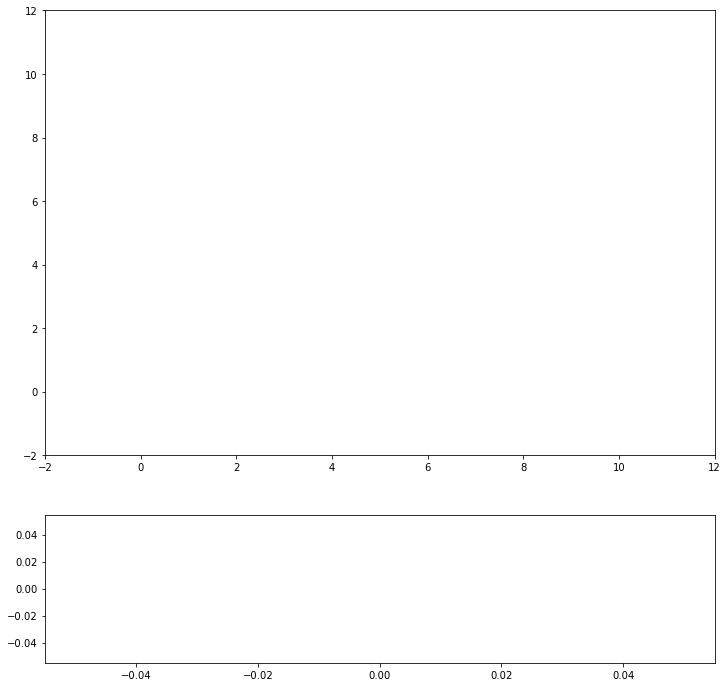

In [5]:
robot = BaseRobot(0, 0, 0)
motion_model = OdometryMotionModel(robot.pose)
robot.motion = motion_model

odometry, sensor = read_simple_data('./data/simple/sensor_data.dat')
landmarks = read_simple_world('./data/simple/world.dat')

landmark_map = LandmarkMap([])
true_map = LandmarkMap(landmarks)
commands = [np.array(odom).T for odom in odometry]

num_landmarks = len(landmarks)
EKF = EKFSLAMKnown(robot.pose, num_landmarks, motion_model)

# Plot true robot path
x = []
y = []
EKF_x = []
EKF_y = []
gtlx = []
gtly = []
cov_dets = []
ellipses = []

fig, (ax, ax1) = plt.subplots(2, 1, 
                              figsize=(12, 12), 
                              gridspec_kw={'height_ratios':[3, 1]})
ax.set_xlim((-2, 12))
ax.set_ylim((-2, 12))

ln, = ax.plot([], [], 'g', zorder=2)
pn, = ax.plot([], [], 'bx', markersize=5, zorder=3)
lm, = ax.plot([], [], 'ro', zorder=2)
gtlm, = ax.plot([], [], 'ko', zorder=2)
sline, = ax.plot([], [], 'k')
det_line, = ax1.plot([], [])
    
def init():
    ln.set_data([], [])
    sline.set_data([], [])
    det_line.set_data([], [])
    return ln, pn, sline, det_line,

counter = 0
def update(frame):
    global counter
    global ellipses
    
    for e in ellipses:
        e.remove()
    ellipses = []
    
    command, readings = frame
    
    # True path
    robot.motion_command(command)
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
    EKF.predict(command)
    
    rx = EKF.mean.item(0)
    ry = EKF.mean.item(1)
    rtheta = normalize_angle(EKF.mean.item(2))
    
    line_x = []
    line_y = []
    
    for reading in readings:
        lid, srange, sbearing = reading
        
        ang = normalize_angle(sbearing + rtheta)
        olx = rx + srange * math.cos(ang)
        oly = ry + srange * math.sin(ang)
        
        line_x.append([rx, olx])
        line_y.append([ry, oly])
    
    EKF.correct(readings, landmark_map)
    
    EKF_x.append(EKF.mean.item(0))
    EKF_y.append(EKF.mean.item(1))
    
    lm_x = []
    lm_y = []
    for key, value in landmark_map.landmarks.items():
        lx, ly = EKF.get_landmark(key)
        tlx, tly = true_map.get(key)
        lm_x.append(lx)
        lm_y.append(ly)
        #Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

        lid = EKF.get_mu_lid(key)
        lm_cov = EKF.cov[lid:lid+EKF.lmsize, lid:lid+EKF.lmsize]

        width, height, angle = cov_ellipse(lm_cov, nsig=2)
        el = Ellipse(xy=(lx, ly), width=width, height=height, angle=angle)
        ellipses.append(el)
        
        gtlx.append(tlx)
        gtly.append(tly)
        
    if counter % 10 == 0:
        for e in ellipses:
            ax.add_artist(e)
        counter = 0
    else:
        counter = counter + 1
    
    cov_det = np.linalg.det(EKF.cov[:EKF.rsize, :EKF.rsize])
    cov_dets.append(cov_det)
        
    cr = range(0, len(cov_dets))
    det_line.set_data(cr, cov_dets)
    ax1.set_xlim((0, len(cov_dets)))
    ax1.set_ylim((0, max(cov_dets)*1.1))
    
    ln.set_data(x, y)
    lm.set_data(lm_x, lm_y)
    gtlm.set_data(gtlx, gtly)
    pn.set_data(EKF_x, EKF_y)
    sline.set_data(line_x, line_y)
    
    return ln, pn, lm, sline, det_line,

ani = FuncAnimation(fig, update, frames=zip(commands, sensor), init_func=init, blit=True, interval=200)

In [6]:
HTML(ani.to_html5_video())